In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-gfozcr6t
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-gfozcr6t
  Resolved https://github.com/facebookresearch/detectron2.git to commit 2c6c380f94a27bd8455a39506c9105f652b9f760


In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
torch:  1.12 ; cuda:  bd13bc6
detectron2: 0.6


In [28]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 293 kB 4.2 MB/s eta 0:00:01


In [32]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import matplotlib.pyplot as plt

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import seaborn as sb

In [22]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

food_classes = ["rice", "bean", "boiled egg", "fried egg", 
                  "salad", "steak", "apple", "chicken breast", "lunch",
                  "spaghetti"]

sample_food_classes = ["rice", "pasta", "bread", "cheese", "cereal", "plate"]

sample_foodXL_classes = ["rice", "pasta", "bread", "cheese", "cereal", "crisp_bread", "carrot","tomato", "ham", "egg","pasta","potato","sweet_potato","salami","nachos","oatmeal","broccoli","paprika", "plate"]


plate_class = ["plate"]
ruler_class = ["ruler"]

directory = os.getcwd()

def get_plate_dicts(data_dir):
  #img_dir = "/home/jalellcf/Project/foodSVplates"
  img_dir = os.path.join(directory, "foodSVplates")
  json_file = os.path.join(img_dir, "plates_bbox.json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          #print(v["Label"]["objects"][0]["polygon"])
          #print(v["External ID"])
          #print(v["Dataset Name"].split("_")[0])
          #print(v["Dataset Name"].split("_")[0])
          if(v["Dataset Name"].split("_")[0] == data_dir):
              record = {}
              file_name = v["External ID"]
              record["file_name"] = img_dir + "/" + data_dir + "/" + file_name
              if(os.path.isfile(record["file_name"])):
                  #print(record["file_name"])
                  record["image_id"] = idx
                  height, width = cv2.imread(record["file_name"]).shape[:2]
                  record["height"] = height
                  record["width"] = width
                  objs = []
                  anno = v["Label"]["objects"] 
                  i = 0
                  for a in anno:
                      #..
                      bbox = [a["bbox"]["left"], a["bbox"]["top"], a["bbox"]["left"]+a["bbox"]["width"], a["bbox"]["top"]+a["bbox"]["height"]]
                      x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[1]
                      x3, y3, x4, y4 = bbox[2], bbox[3], bbox[0], bbox[3]
                      poly_bbox = [x1, y1, x2, y2, x3, y3, x4, y4]
                      obj = {
                          "bbox": bbox,
                          #"bbox": [1,2,3,4],
                          "bbox_mode": BoxMode.XYXY_ABS,
                          #"segmentation": [poly_bbox],
                          #"category_id": 1,
                          "category_id": 0,
                      }
                      objs.append(obj)
                  record["annotations"] = objs
                  dataset_dicts.append(record)
  #print(dataset_dicts)
  return dataset_dicts


def get_food_dicts(data_dir):
  #img_dir = "/home/jalellcf/Project/foodSV_XL"
  img_dir = os.path.join(directory, "foodSV_XL")
  json_file = os.path.join(img_dir, "calories_training_validation.json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          #print(v["Label"]["objects"][0]["polygon"])
          #print(v["External ID"])
          #print(v["Dataset Name"].split("_")[0])
          #print(v["Dataset Name"].split("_")[0])
          if(v["Dataset Name"].split("_")[0] == data_dir):
              record = {}
              file_name = v["External ID"]
              record["file_name"] = img_dir + "/" + data_dir + "/" + file_name
              if(os.path.isfile(record["file_name"])):
                  #print(record["file_name"])
                  record["image_id"] = idx
                  height, width = cv2.imread(record["file_name"]).shape[:2]
                  record["height"] = height
                  record["width"] = width
                  objs = []
                  anno = v["Label"]["objects"] 
                  i = 0
                  for a in anno:
                      poly_list = a["polygon"]
                      poly = [val for item in poly_list for val in [item['x'], item['y']]]
                      px = [point['x'] for point in poly_list]
                      py = [point['y'] for point in poly_list]
                      #print(poly)
                      #print(px)
                      #print(py)
                      obj = {
                          "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                          "bbox_mode": BoxMode.XYXY_ABS,
                          "segmentation": [poly],
                          #"category_id": 1,
                          "category_id": sample_foodXL_classes.index(v["Label"]["classifications"][i]["answer"]["value"]),
                      }
                      objs.append(obj)
                      #print(v["Label"]["classifications"][i]["answer"]["value"]) 
                      i += 1
                          
                  record["annotations"] = objs
                  record["label"] = v["Label"]["classifications"][0]["answer"]["value"]
                  dataset_dicts.append(record)
  #print(dataset_dicts)
  return dataset_dicts

def get_ruler_dicts(data_dir):
  #img_dir = "/home/jalellcf/Project/foodSVruler"
  img_dir = os.path.join(directory, "foodSVruler")
  json_file = os.path.join(img_dir, "ruler_bbox.json")
  with open(json_file) as f:
      imgs_anns = json.load(f)
      dataset_dicts = []
      for idx, v in enumerate(imgs_anns):
          #print(v["Label"]["objects"][0]["polygon"])
          #print(v["External ID"])
          #print(v["Dataset Name"].split("_")[0])
          #print(v["Dataset Name"].split("_")[0])
          if(v["Dataset Name"].split("_")[0] == data_dir):
              record = {}
              file_name = v["External ID"]
              record["file_name"] = img_dir + "/" + data_dir + "/" + file_name
              if(os.path.isfile(record["file_name"])):
                  #print(record["file_name"])
                  record["image_id"] = idx
                  height, width = cv2.imread(record["file_name"]).shape[:2]
                  record["height"] = height
                  record["width"] = width
                  objs = []
                  anno = v["Label"]["objects"] 
                  i = 0
                  for a in anno:
                      #..
                      bbox = [a["bbox"]["left"], a["bbox"]["top"], a["bbox"]["left"]+a["bbox"]["width"], a["bbox"]["top"]+a["bbox"]["height"]]
                      x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[1]
                      x3, y3, x4, y4 = bbox[2], bbox[3], bbox[0], bbox[3]
                      poly_bbox = [x1, y1, x2, y2, x3, y3, x4, y4]
                      obj = {
                          "bbox": bbox,
                          #"bbox": [1,2,3,4],
                          "bbox_mode": BoxMode.XYXY_ABS,
                          #"segmentation": [poly_bbox],
                          #"category_id": 1,
                          "category_id": 0,
                      }
                      objs.append(obj)
                  record["annotations"] = objs
                  dataset_dicts.append(record)
  #print(dataset_dicts)
  return dataset_dicts



if "plate_training" in DatasetCatalog.list():
  DatasetCatalog.remove("plate_training")
  MetadataCatalog.remove("plate_training")
    
if "plate_validation" in DatasetCatalog.list():
  DatasetCatalog.remove("plate_validation")
  MetadataCatalog.remove("plate_validation")
    
for d in ["training", "validation"]:
  DatasetCatalog.register("plate_" + d, lambda d=d: get_plate_dicts(d))
  if "plate_training" in DatasetCatalog.list():
        #MetadataCatalog.remove("food_training")
        pass
  MetadataCatalog.get("plate_" + d).set(thing_classes=plate_class)
  #MetadataCatalog.get("food_" + d).set(thing_classes=food_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=["food"])

#MetadataCatalog.remove("food_training")
plate_metadata = MetadataCatalog.get("plate_training")
print(plate_metadata)
#print(food_metadata.get("thing_classes"))


############################
#register food as well

if "food_training" in DatasetCatalog.list():
  DatasetCatalog.remove("food_training")
  MetadataCatalog.remove("food_training")
    
if "food_validation" in DatasetCatalog.list():
  DatasetCatalog.remove("food_validation")
  MetadataCatalog.remove("food_validation")
    
for d in ["training", "validation"]:
  DatasetCatalog.register("food_" + d, lambda d=d: get_food_dicts(d))
  if "food_training" in DatasetCatalog.list():
        #MetadataCatalog.remove("food_training")
        pass
  MetadataCatalog.get("food_" + d).set(thing_classes=sample_foodXL_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=food_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=["food"])

#MetadataCatalog.remove("food_training")
food_metadata = MetadataCatalog.get("food_training")
print(food_metadata)
#print(food_metadata.get("thing_classes"))


#############################
#register ruler also 
if "ruler_training" in DatasetCatalog.list():
  DatasetCatalog.remove("ruler_training")
  MetadataCatalog.remove("ruler_training")
    
if "ruler_validation" in DatasetCatalog.list():
  DatasetCatalog.remove("ruler_validation")
  MetadataCatalog.remove("ruler_validation")
    
for d in ["training", "validation"]:
  DatasetCatalog.register("ruler_" + d, lambda d=d: get_ruler_dicts(d))
  if "ruler_training" in DatasetCatalog.list():
        #MetadataCatalog.remove("food_training")
        pass
  MetadataCatalog.get("ruler_" + d).set(thing_classes=ruler_class)
  #MetadataCatalog.get("food_" + d).set(thing_classes=food_classes)
  #MetadataCatalog.get("food_" + d).set(thing_classes=["food"])

#MetadataCatalog.remove("food_training")
ruler_metadata = MetadataCatalog.get("ruler_training")
print(ruler_metadata)
#print(food_metadata.get("thing_classes"))




Metadata(name='plate_training', thing_classes=['plate'])
Metadata(name='food_training', thing_classes=['rice', 'pasta', 'bread', 'cheese', 'cereal', 'crisp_bread', 'carrot', 'tomato', 'ham', 'egg', 'pasta', 'potato', 'sweet_potato', 'salami', 'nachos', 'oatmeal', 'broccoli', 'paprika', 'plate'])
Metadata(name='ruler_training', thing_classes=['ruler'])


/home/jalellcf/Project/foodSVplates/training/20190107_115926.jpeg


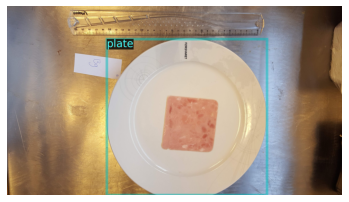

/home/jalellcf/Project/foodSVplates/training/20190107_115743.jpeg


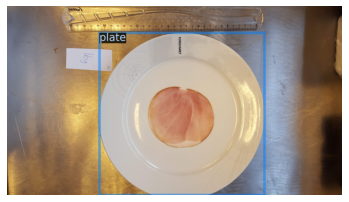

/home/jalellcf/Project/foodSVplates/training/20190107_115540.jpeg


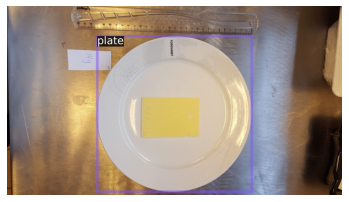

/home/jalellcf/Project/foodSV_XL/training/image026.jpg


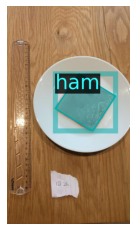

/home/jalellcf/Project/foodSV_XL/training/image003.jpg


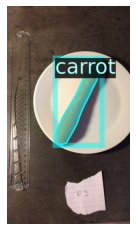

/home/jalellcf/Project/foodSV_XL/training/image018.jpg


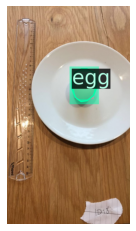

/home/jalellcf/Project/foodSVruler/training/20190107_114723.jpeg


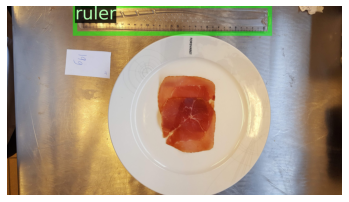

/home/jalellcf/Project/foodSVruler/training/20190107_114334.jpeg


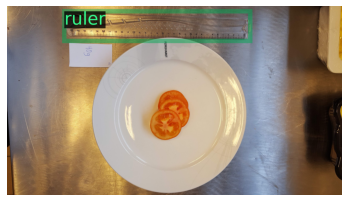

/home/jalellcf/Project/foodSVruler/training/20181126_092929.jpeg


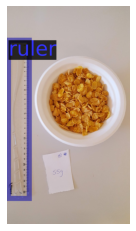

In [41]:
dataset_dicts = get_plate_dicts("training")
#dataset_dicts = get_foodSV_sample_dicts("validation")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    print(d["file_name"])
    #print(d["annotations"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=plate_metadata, scale=1)
    visualizer._default_font_size = 90
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


dataset_dicts = get_food_dicts("training")


for d in random.sample(dataset_dicts, 3):
#for d in dataset_dicts:
    img = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    print(d["file_name"])
    #print(d["annotations"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=food_metadata, scale=1)
    visualizer._default_font_size = 90
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()
    

dataset_dicts = get_ruler_dicts("training")


for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    print(d["file_name"])
    #print(d["annotations"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ruler_metadata, scale=1)
    visualizer._default_font_size = 150
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()




In [86]:
from detectron2.engine import DefaultTrainer

import os
import numpy as np
from detectron2.engine import DefaultTrainer, hooks
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import HookBase
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt

# ...


class LossPlotter(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.losses = []
    
    def after_step(self):
        data = {"total_loss": self.trainer.storage.history("total_loss").latest}
        self.losses.append(data["total_loss"])

    def plot_loss(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots()
        ax.plot(self.losses)
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Loss")
        ax.set_title("Training Loss Curve")
        plt.show()




plate_cfg = get_cfg()
plate_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
plate_cfg.DATASETS.TRAIN = ("plate_training",)
plate_cfg.DATASETS.TEST = ()
plate_cfg.DATALOADER.NUM_WORKERS = 2
plate_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
plate_cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
plate_cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
plate_cfg.SOLVER.MAX_ITER = 100    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
plate_cfg.SOLVER.STEPS = []        # do not decay learning rate
plate_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
plate_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

plate_cfg.OUTPUT_DIR = "./output_plate_detection"

os.makedirs(plate_cfg.OUTPUT_DIR, exist_ok=True)

def train_plate_prediction():
    trainer = DefaultTrainer(plate_cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    print("\n PLATE TRAINING FINISHED \n")


food_cfg = get_cfg()
food_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
food_cfg.DATASETS.TRAIN = ("food_training",)
food_cfg.DATASETS.TEST = ()
food_cfg.DATALOADER.NUM_WORKERS = 2
food_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
food_cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
food_cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
food_cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
food_cfg.SOLVER.STEPS = []        # do not decay learning rate
food_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
food_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 19  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

food_cfg.OUTPUT_DIR = "./output_food_detection"

os.makedirs(food_cfg.OUTPUT_DIR, exist_ok=True)

def train_food_prediction():
    trainer = DefaultTrainer(food_cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    print("\n FOOD TRAINING FINISHED \n")
    

ruler_cfg = get_cfg()
ruler_cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
ruler_cfg.DATASETS.TRAIN = ("ruler_training",)
ruler_cfg.DATASETS.TEST = ()
ruler_cfg.DATALOADER.NUM_WORKERS = 2
ruler_cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
ruler_cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
ruler_cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
ruler_cfg.SOLVER.MAX_ITER = 800    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
ruler_cfg.SOLVER.STEPS = []        # do not decay learning rate
ruler_cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
ruler_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

ruler_cfg.OUTPUT_DIR = "./output_ruler_detection"

os.makedirs(ruler_cfg.OUTPUT_DIR, exist_ok=True)

def train_ruler_prediction():
    trainer = DefaultTrainer(ruler_cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

    print("\n RULER TRAINING FINISHED \n")
    
    
#train_plate_prediction()
train_ruler_prediction()
#train_food_prediction()



[06/06 18:22:28 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[06/06 18:22:28 d2.engine.train_loop]: Starting training from iteration 0
[06/06 18:22:36 d2.utils.events]:  eta: 0:04:54  iter: 19  total_loss: 1.355  loss_cls: 0.8777  loss_box_reg: 0.2978  loss_rpn_cls: 0.1271  loss_rpn_loc: 0.03861    time: 0.3672  last_time: 0.4072  data_time: 0.0643  last_data_time: 0.0665   lr: 6.1816e-06  max_mem: 5036M
[06/06 18:22:43 d2.utils.events]:  eta: 0:04:45  iter: 39  total_loss: 1.164  loss_cls: 0.7602  loss_box_reg: 0.3083  loss_rpn_cls: 0.06603  loss_rpn_loc: 0.03756    time: 0.3628  last_time: 0.3214  data_time: 0.0156  last_data_time: 0.0110   lr: 1.2425e-05  max_mem: 5036M
[06/06 18:22:51 d2.utils.events]:  eta: 0:04:35  iter: 59  total_loss: 0.9507  loss_cls: 0.5499  loss_box_reg: 0.3633  loss_rpn_cls: 0.02357  loss_rpn_loc: 0.03496    time: 0.3633  last_time: 0.3157  data_time: 0.0197  last_data_time: 0.0017   lr: 1.8669e-05  max_mem: 5036M
[06/06 18:22:58 d2.utils.events]:  eta: 0:04:24  iter: 79  total_loss: 0.809  loss_cls: 0.401  loss_box_

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


[06/06 18:27:19 d2.utils.events]:  eta: 0:00:00  iter: 799  total_loss: 0.1166  loss_cls: 0.02896  loss_box_reg: 0.0724  loss_rpn_cls: 0.0001013  loss_rpn_loc: 0.01393    time: 0.3613  last_time: 0.3814  data_time: 0.0164  last_data_time: 0.0109   lr: 0.00024969  max_mem: 5036M
[06/06 18:27:19 d2.engine.hooks]: Overall training speed: 798 iterations in 0:04:48 (0.3613 s / it)
[06/06 18:27:19 d2.engine.hooks]: Total training time: 0:04:50 (0:00:01 on hooks)

 RULER TRAINING FINISHED 



Text(0.5, 1.0, 'Total Loss vs. Iteration')

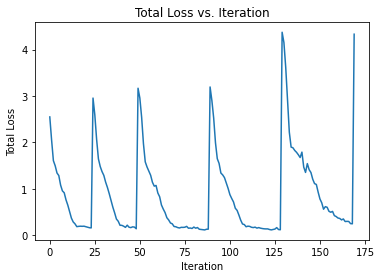

In [83]:
import json

# Read the JSON file
with open('/home/jalellcf/Project/metrics_food.json', 'r') as file:
    json_data = json.load(file)
    
json_data.pop(0)

loss_array = []

# Iterate through the list
for item in json_data:
    if "total_loss" in item:
        loss_array.append(item["total_loss"])
        
#print(loss_array)

# Plot the loss_array
plt.plot(loss_array)
plt.xlabel("Iteration")
plt.ylabel("Total Loss")
plt.title("Total Loss vs. Iteration")
#plt.show()


In [72]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
plate_cfg.MODEL.WEIGHTS = os.path.join(plate_cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
plate_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
plate_predictor = DefaultPredictor(plate_cfg)

food_cfg.MODEL.WEIGHTS = os.path.join(food_cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
food_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
food_predictor = DefaultPredictor(food_cfg)

ruler_cfg.MODEL.WEIGHTS = os.path.join(ruler_cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
ruler_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
ruler_predictor = DefaultPredictor(ruler_cfg)



[06/05 12:25:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_plate_detection/model_final.pth ...


/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


[06/05 12:25:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_food_detection/model_final.pth ...
[06/05 12:25:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output_ruler_detection/model_final.pth ...


In [47]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [87]:
calories_per_sq_cm = {
  "bread": 0.73,
  "cheese": 0.65,
  "cereal": 1.67,
  "egg": 3.68,
  'rice': 2.93, 
  'pasta': 2,
  'crisp_bread': 0.83, 
  'carrot': 0.62, 
  'tomato': 0.2, 
  'ham': 0.37, 
  'potato': 2, 
  'sweet_potato': 1.9, 
  'salami': 0.57, 
  'nachos': 0.6, 
  'oatmeal': 1.6, 
  'broccoli': 0.1, 
  'paprika': 0.2
    
}

/home/jalellcf/Project/foodSV_XL/validation/20181126_084940.jpeg
[142.00574]
[819.4252]
655.7203229511069


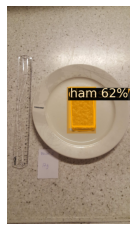

97500 pixels segmented
148.69 square centimeters of food
55.02 calories
/home/jalellcf/Project/foodSV_XL/validation/20181126_092929.jpeg
[158.33694]
[1166.0321]
1327.7645202211716


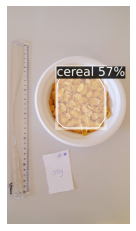

140999 pixels segmented
106.19 square centimeters of food
177.34 calories
/home/jalellcf/Project/foodSV_XL/validation/20181128_061219.jpeg
[181.17645]
[837.6284]
685.1771158094052


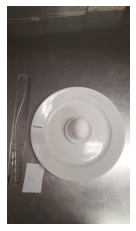

0 pixels segmented
0.0 square centimeters of food
/home/jalellcf/Project/foodSV_XL/validation/20190107_114723.jpeg
[1662.1855]
[235.3623]
2698.1062424220145


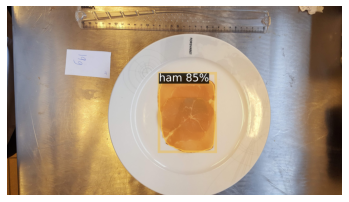

274974 pixels segmented
101.91 square centimeters of food
37.71 calories
/home/jalellcf/Project/foodSV_XL/validation/20190107_115423.jpeg
[1776.9436   546.67065]
[276.8178 512.7086]
3083.5239942139597


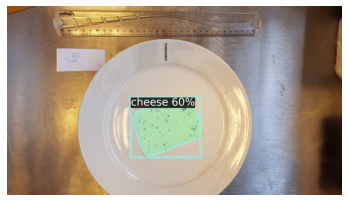

202989 pixels segmented
65.83 square centimeters of food
42.79 calories
/home/jalellcf/Project/foodSV_XL/validation/20190107_115639.jpeg
[1646.9192]
[217.55905]
2648.772281825135


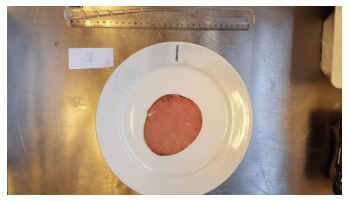

0 pixels segmented
0.0 square centimeters of food
/home/jalellcf/Project/foodSV_XL/validation/20190107_120220.jpeg
[1648.5027]
[226.11324]
2653.8682658742764


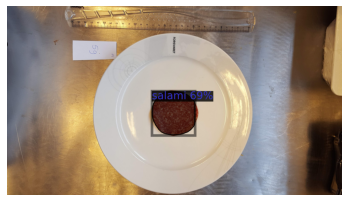

114873 pixels segmented
43.29 square centimeters of food
24.67 calories
/home/jalellcf/Project/foodSV_XL/validation/20190125_151241.jpeg
[1720.4443]
[255.58833]
2890.555383847095


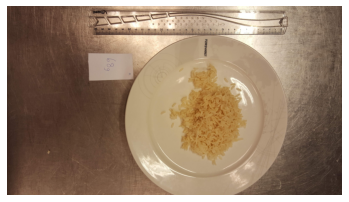

0 pixels segmented
0.0 square centimeters of food
/home/jalellcf/Project/foodSV_XL/validation/20190212_075739.jpeg
[1708.8364]
[222.85765]
2851.6815723406617


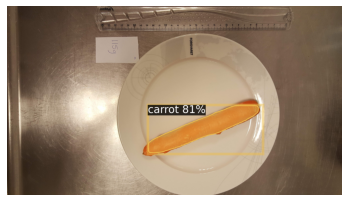

140476 pixels segmented
49.26 square centimeters of food
30.54 calories
/home/jalellcf/Project/foodSV_XL/validation/20190212_081420.jpeg
[138.96289 236.09537]
[917.1659  279.74872]
821.4778088866879


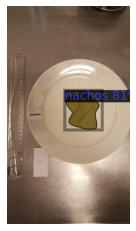

47513 pixels segmented
57.84 square centimeters of food
34.7 calories
/home/jalellcf/Project/foodSV_XL/validation/image008.jpg
[107.68391 126.49448]
[723.13824 183.76547]
510.67277426267174


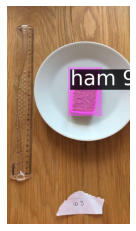

20268 pixels segmented
39.69 square centimeters of food
14.68 calories
/home/jalellcf/Project/foodSV_XL/validation/image012.jpg
[94.50941]
[685.5041]
458.902203635811


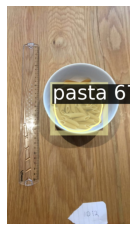

39479 pixels segmented
86.03 square centimeters of food
172.06 calories
/home/jalellcf/Project/foodSV_XL/validation/image020.jpg
[107.417564]
[725.2305]
513.6321497387289


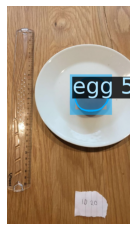

15817 pixels segmented
30.79 square centimeters of food
113.32 calories
/home/jalellcf/Project/foodSV_XL/validation/image016.jpg
[122.40451]
[732.35596]
523.7746560538653


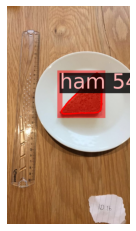

18778 pixels segmented
35.85 square centimeters of food
13.26 calories
/home/jalellcf/Project/foodSV_XL/validation/image034.jpg
[136.7818   126.398834]
[912.5438  522.32654]
813.2189739623718


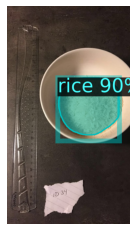

62880 pixels segmented
77.32 square centimeters of food
226.55 calories
/home/jalellcf/Project/foodSV_XL/validation/image038.jpg
[117.480385]
[794.8914]
617.0433272818664


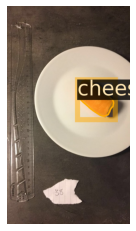

14996 pixels segmented
24.3 square centimeters of food
15.8 calories
/home/jalellcf/Project/foodSV_XL/validation/image043.jpg
[99.981575]
[818.49695]
654.2355998845451


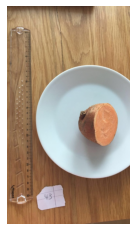

0 pixels segmented
0.0 square centimeters of food
/home/jalellcf/Project/foodSV_XL/validation/image046.jpg
[121.36182]
[786.0928]
603.4588363775983


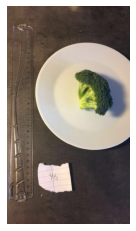

0 pixels segmented
0.0 square centimeters of food
['ham' 'cereal' 'None' 'ham' 'cheese' 'None' 'salami' 'None' 'carrot'
 'nachos' 'ham' 'pasta' 'egg' 'ham' 'rice' 'cheese' 'None' 'None']
Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]]


ValueError: The number of FixedLocator locations (15), usually from a call to set_ticks, does not match the number of ticklabels (19).

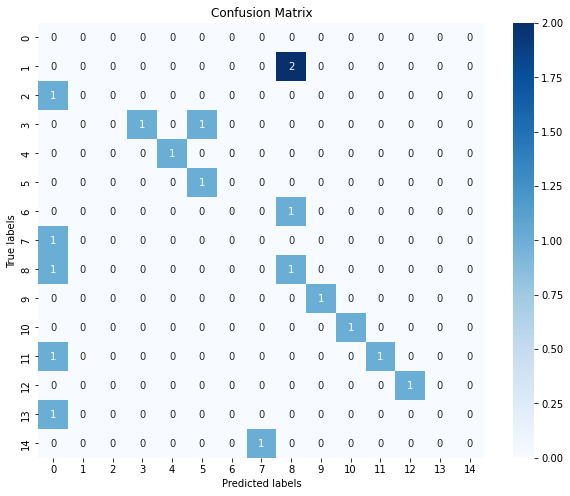

In [88]:
from detectron2.utils.visualizer import ColorMode
from sklearn.metrics import confusion_matrix

ruler_length_in_cm = 32


dataset_dicts = get_food_dicts("validation")

true_labels = []
predicted_labels = []


#specified_filename = "/home/jalellcf/Project/foodSV_sample/validation/20190107_115540.jpeg"
#specific_entry = next((d for d in dataset_dicts if d["file_name"] == specified_filename), None)
#for d in random.sample(dataset_dicts, 3):  
for d in dataset_dicts:
#for d in [specific_entry]:
    print(d["file_name"])
    im = cv2.imread(d["file_name"], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)  # Convert to BGR color space
    
    
    
    ############
    # plate prediction
    ''''
    outputs = plate_predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    widths = boxes[:, 2] - boxes[:, 0]  # calculate width as difference between x-coordinates
    heights = boxes[:, 3] - boxes[:, 1]  # calculate height as difference between y-coordinates

    print(widths)
    print(heights)
    v = Visualizer(im[:, :, ::-1],
                   metadata=plate_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v._default_font_size = 60
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print("plate prediction:")
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    '''
    ############
    # ruler prediction
    outputs = ruler_predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    
    instances = outputs["instances"]
    boxes = instances.pred_boxes.tensor.cpu().numpy()
    widths = boxes[:, 2] - boxes[:, 0]  # calculate width as difference between x-coordinates
    heights = boxes[:, 3] - boxes[:, 1]  # calculate height as difference between y-coordinates

    print(widths)
    print(heights)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ruler_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v._default_font_size = 150
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #print("ruler prediction:")
    #plt.imshow(out.get_image()[:, :, ::-1])
    #plt.axis('off')
    #plt.show()
    
    if(widths.size > 0):
        ruler_width = widths[0]
        ruler_height = heights[0]

        pixel_per_sq_cm = (max(ruler_width, ruler_height)/ruler_length_in_cm) ** 2
        print(pixel_per_sq_cm)
    else:
        print("no ruler detected")
    
    ############
    # food prediction
    outputs = food_predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=food_metadata, 
                   scale=1.0, 
                   instance_mode=ColorMode.IMAGE
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    v._default_font_size = 90
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    mask_tensor = outputs["instances"].pred_masks
    num_true = torch.sum(mask_tensor)
    #print("\n food prediction:")
    #print(d["Label"]["classifications"][0]["answer"]["value"])
    #print(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    instances = outputs["instances"]
    predicted_classes = instances.pred_classes.tolist()
    
    true_label = d["label"]
    true_labels.append(true_label)
    
    if(predicted_classes):
        predicted_class = food_metadata.thing_classes[predicted_classes[0]]
        predicted_labels.append(predicted_class)
    else:
        predicted_labels.append("None")
    
    food_sq_cm = num_true.item() / pixel_per_sq_cm
    print(str(num_true.item()) + " pixels segmented")
    print(str(round(food_sq_cm, 2)) + " square centimeters of food")
    if(predicted_classes):
        prediction_calories_per_sq_cm = calories_per_sq_cm[food_metadata.thing_classes[predicted_classes[0]]]
        calories_calculation = prediction_calories_per_sq_cm * food_sq_cm
        print(str(round(calories_calculation, 2)) + " calories")
    

# Convert labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
print(predicted_labels)
# Build confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a figure and axes
plt.figure(figsize=(10, 8))
ax = plt.subplot()

# Create the heatmap using Seaborn
sb.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)

# Set labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(sample_foodXL_classes, rotation=90)
ax.yaxis.set_ticklabels(sample_foodXL_classes, rotation=0)

# Show the plot
plt.imshow()

    